In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from ptic import pmi_tfidf_classifier as ptah
path = "../datasets/"
plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [14.0, 6.0]
plt.rcParams['figure.dpi'] = 140
plt.rcParams["axes.labelsize"] = 14
np.random.seed(42)

[nltk_data] Downloading package stopwords to /home/aln/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/aln/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# DILI dataset

In [2]:
data_raw = pd.read_csv(path + 'DILI_CAMDA_challenge/DILI_initial_set.csv')
data_raw['abs_text'] = data_raw['Abstract'] + ' ' + data_raw['Title']
data = data_raw.loc[np.random.permutation(data_raw.index)]
data = data_raw.sample(frac=1)
idx = int(data.shape[0] * 0.1)
test_data = data.iloc[:idx]
train_data = data.iloc[idx:]
targets_train = train_data['Label'].values
targets_test = test_data['Label'].values


data_raw_imdb = pd.read_csv(path + 'IMDB_Dataset.csv')
data_raw_imdb['abs_text'] = data_raw_imdb['review']
data_imdb = data_raw_imdb.loc[np.random.permutation(data_raw_imdb.index)]
data_imdb = data_raw_imdb.sample(frac=1)
data_imdb = data_imdb.replace(to_replace=['negative', 'positive'], value=[0, 1])
idx = int(data_imdb.shape[0] * 0.1)
test_imdb_data = data_imdb.iloc[:idx]
train_imdb_data = data_imdb.iloc[idx:]
targets_imdb_train = train_imdb_data['sentiment'].values
targets_imdb_test = test_imdb_data['sentiment'].values

In [3]:
tokenized_texts = ptah.tokenization(train_data, 'abs_text')
tokenized_test_texts = ptah.tokenization(test_data, 'abs_text')
tokenized_imdb_texts = ptah.tokenization(train_imdb_data, 'abs_text')
tokenized_imdb_test_texts = ptah.tokenization(test_imdb_data, 'abs_text')

In [4]:
N = len(tokenized_texts)
N_imdb = len(tokenized_imdb_texts)
scores = {"accuracies":[], "precisions":[], "recalls":[], "F1s":[], "size":[]}
scores_imdb = {"accuracies":[], "precisions":[], "recalls":[], "F1s":[], "size":[]}

## Dependence of scores on the size of dictionary
### DILI dataset

In [5]:
dict_size = [i for i in np.arange(0.02, 1, 0.01)]
for i in dict_size:
    part = tokenized_texts[:int(N * i)]
    scores["size"].append(len(part))
    word2text_count = ptah.get_word_stat(part)
    words_pmis = ptah.create_pmi_dict(part, targets_train, min_count=5)

    results = ptah.classify_pmi_based(words_pmis, word2text_count, tokenized_test_texts, N)

    precision = np.sum( np.logical_and(results, targets_test) ) / np.sum(results)
    recall = np.sum( np.logical_and(results, targets_test) ) / np.sum(targets_test)
    F1 = 2 * (recall * precision)/(recall + precision)

    accuracy = (results == targets_test).mean()
    scores["accuracies"].append( accuracy )
    scores["precisions"].append( precision )
    scores["recalls"].append( recall )
    scores["F1s"].append( F1 )

# IMDB dataset

In [6]:
path = "../datasets/"
data_raw = pd.read_csv(path + 'IMDB_Dataset.csv')
indices = np.random.permutation(data_raw.index)
data = data_raw.loc[indices]
data = data_raw.sample(frac=1)
data = data.replace(to_replace=['negative', 'positive'], value=[0, 1])
idx = int(data.shape[0] * 0.1)
test_data = data.iloc[:idx]
train_data = data.iloc[idx:]
targets_train = train_data["sentiment"].values
targets_test = test_data["sentiment"].values
tokenized_texts = ptah.tokenization(train_data, 'review')
tokenized_test_texts = ptah.tokenization(test_data, 'review')
N = len(tokenized_texts)

In [7]:
for i in dict_size:
    part = tokenized_imdb_texts[:int(N_imdb * i)]
    scores_imdb["size"].append(len(part))
    word2text_count = ptah.get_word_stat(part)
    words_pmis = ptah.create_pmi_dict(part, targets_imdb_train, min_count=5)

    results = ptah.classify_pmi_based(words_pmis, word2text_count, tokenized_imdb_test_texts, N_imdb)

    precision = np.sum( np.logical_and(results, targets_imdb_test) ) / np.sum(results)
    recall = np.sum( np.logical_and(results, targets_imdb_test) ) / np.sum(targets_imdb_test)
    F1 = 2 * (recall * precision)/(recall + precision)

    accuracy = (results == targets_imdb_test).mean()
    scores_imdb["accuracies"].append( accuracy )
    scores_imdb["precisions"].append( precision )
    scores_imdb["recalls"].append( recall )
    scores_imdb["F1s"].append( F1 )

### Plots

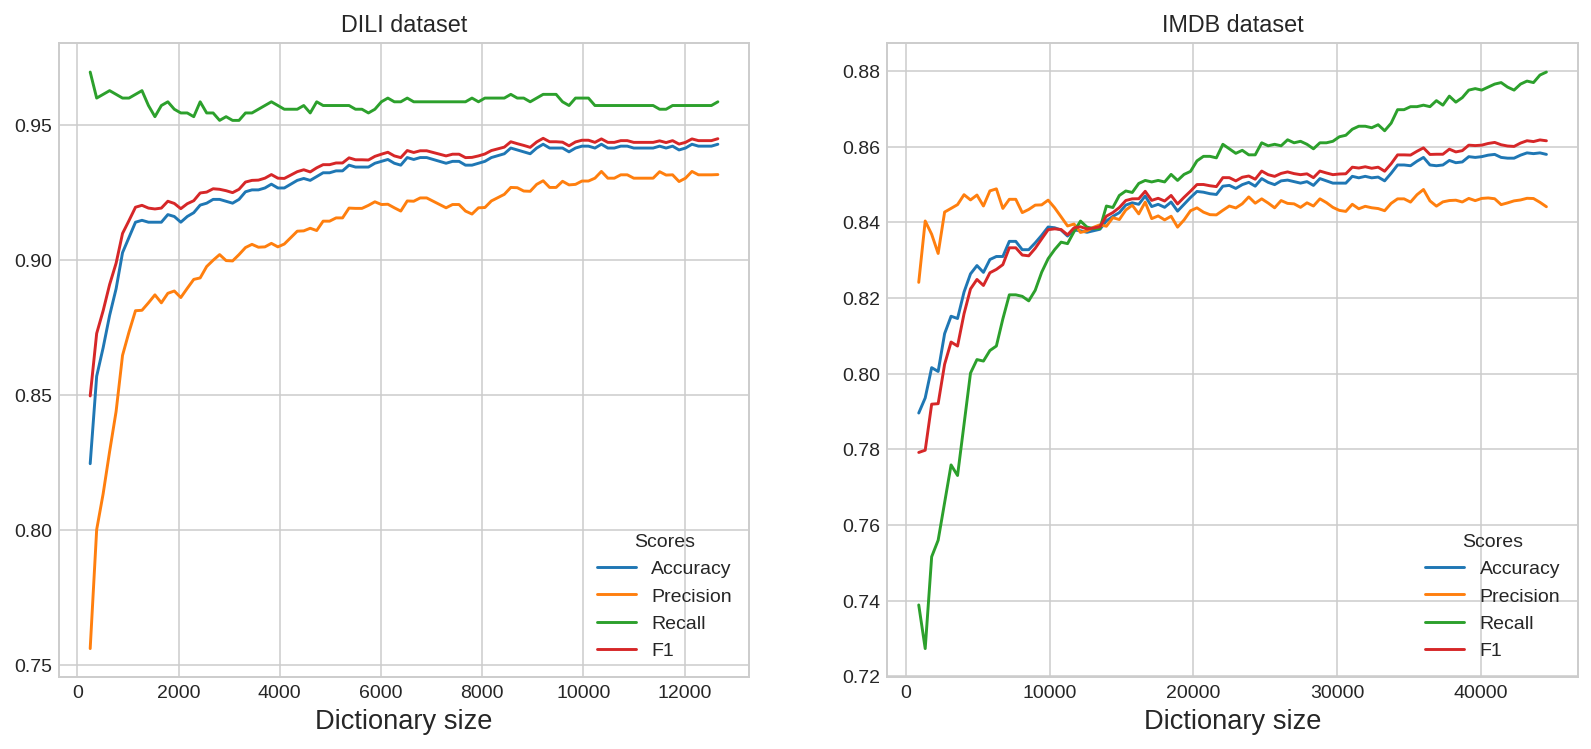

In [14]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(scores["size"], scores["accuracies"], label="Accuracy")
axs[0].plot(scores["size"], scores["precisions"], label="Precision")
axs[0].plot(scores["size"], scores["recalls"], label="Recall")
axs[0].plot(scores["size"], scores["F1s"], label="F1")
axs[0].legend(title="Scores");
axs[0].set(xlabel="Dictionary size");
axs[0].set_title("DILI dataset")

axs[1].plot(scores_imdb["size"], scores_imdb["accuracies"], label="Accuracy")
axs[1].plot(scores_imdb["size"], scores_imdb["precisions"], label="Precision")
axs[1].plot(scores_imdb["size"], scores_imdb["recalls"], label="Recall")
axs[1].plot(scores_imdb["size"], scores_imdb["F1s"], label="F1")
axs[1].legend(title="Scores");
axs[1].set(xlabel="Dictionary size");
axs[1].set_title("IMDB dataset")
plt.savefig("../plots/score_dict_size.png")

## Dependence of scores on the min_count parameter
### DILI dataset

In [8]:
min_counts = [i for i in np.arange(0, 50, 1)]
scores2 = {"accuracies":[], "precisions":[], "recalls":[], "F1s":[], "size":[]}
scores2_imdb = {"accuracies":[], "precisions":[], "recalls":[], "F1s":[], "size":[]}

for i in min_counts:
    part = tokenized_texts[:int(N * i)]
    scores2["size"].append(len(part))
    word2text_count = ptah.get_word_stat(tokenized_texts)
    words_pmis = ptah.create_pmi_dict(tokenized_texts, targets_train, min_count=i)

    results = ptah.classify_pmi_based(words_pmis, word2text_count, tokenized_test_texts, N)

    precision = np.sum( np.logical_and(results, targets_test) ) / np.sum(results)
    recall = np.sum( np.logical_and(results, targets_test) ) / np.sum(targets_test)
    F1 = 2 * (recall * precision)/(recall + precision)

    accuracy = (results == targets_test).mean()
    scores2["accuracies"].append( accuracy )
    scores2["precisions"].append( precision )
    scores2["recalls"].append( recall )
    scores2["F1s"].append( F1 )

### IMDB dataset

In [9]:
for i in min_counts:
    part = tokenized_imdb_texts[:int(N_imdb * i)]
    scores2_imdb["size"].append(len(part))
    word2text_count = ptah.get_word_stat(tokenized_imdb_texts)
    words_pmis = ptah.create_pmi_dict(tokenized_imdb_texts, targets_imdb_train, min_count=i)

    results = ptah.classify_pmi_based(words_pmis, word2text_count, tokenized_imdb_test_texts, N_imdb)

    precision = np.sum( np.logical_and(results, targets_imdb_test) ) / np.sum(results)
    recall = np.sum( np.logical_and(results, targets_imdb_test) ) / np.sum(targets_imdb_test)
    F1 = 2 * (recall * precision)/(recall + precision)

    accuracy = (results == targets_imdb_test).mean()
    scores2_imdb["accuracies"].append( accuracy )
    scores2_imdb["precisions"].append( precision )
    scores2_imdb["recalls"].append( recall )
    scores2_imdb["F1s"].append( F1 )

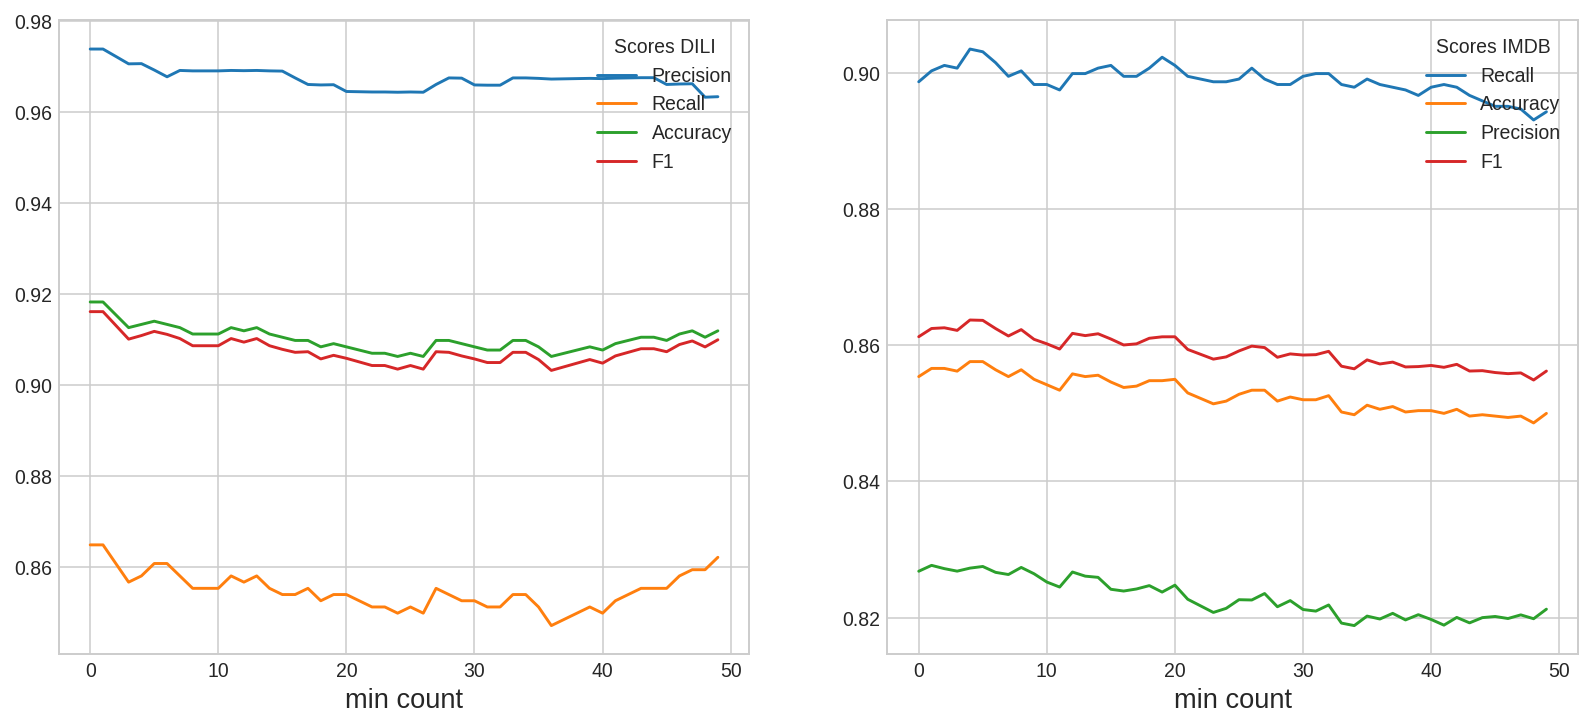

In [ ]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(min_counts, scores2["precisions"], label="Precision")
axs[0].plot(min_counts, scores2["recalls"], label="Recall")
axs[0].plot(min_counts, scores2["accuracies"], label="Accuracy")
axs[0].plot(min_counts, scores2["F1s"], label="F1")
axs[0].title(title="Scores DILI");
axs[0].set(xlabel="min count");

axs[1].plot(min_counts, scores2_imdb["recalls"], label="Recall")
axs[1].plot(min_counts, scores2_imdb["accuracies"], label="Accuracy")
axs[1].plot(min_counts, scores2_imdb["precisions"], label="Precision")
axs[1].plot(min_counts, scores2_imdb["F1s"], label="F1")
axs[1].title(title="Scores IMDB");
axs[1].set(xlabel="min count");


## Distribution of words for different classes for DILI and IMDB datasets

In [44]:
def create_dict(tokenized_texts, targets):
    np.seterr(divide = 'ignore')
    # words count
    d = {0:defaultdict(int), 1:defaultdict(int), 'tot':defaultdict(int)}
    for idx, words in enumerate(tokenized_texts):
        target = targets[idx]
        for w in words:
            d[ target ][w] += 1
    return d

In [ ]:
dictionary_dili = create_dict(tokenized_texts, targets_train)
dictionary_imdb = create_dict(tokenized_imdb_texts, targets_imdb_train)
values0 = list(dictionary_dili[0].values())
values1 = list(dictionary_dili[1].values())
values0_imdb = list(dictionary_imdb[0].values())
values1_imdb = list(dictionary_imdb[1].values())

TypeError: create_dict() got an unexpected keyword argument 'min_count'

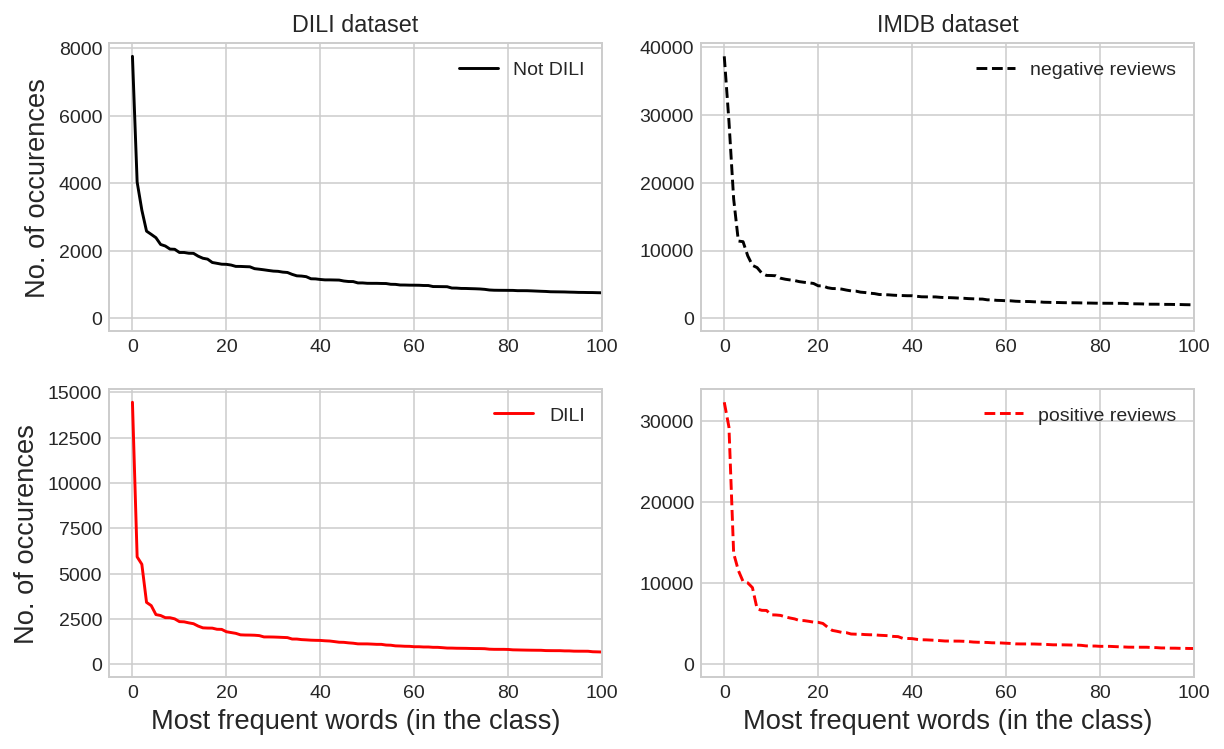

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs[0, 0].plot(sorted(values0, reverse=True), color= "black", label="Not DILI")
axs[0, 0].legend()
axs[1, 0].plot(sorted(values1, reverse=True), color="red", label="DILI")
axs[1, 0].legend()
axs[0, 0].set(ylabel="No. of occurences")
axs[1, 0].set(ylabel="No. of occurences", xlabel="Most frequent words (in the class)")
axs[0, 0].set_title("DILI dataset")
axs[0, 0].set_xlim(-5, 100);
axs[1, 0].set_xlim(-5, 100);

axs[0, 1].plot(sorted(values0_imdb, reverse=True), "k--", label="negative reviews")
axs[0, 1].legend()
axs[1, 1].plot(sorted(values1_imdb, reverse=True), "r--", label="positive reviews")
axs[1, 1].legend()
axs[1, 1].set(xlabel="Most frequent words (in the class)")
axs[0, 1].set_title("IMDB dataset")
axs[0, 1].set_xlim(-5, 100);
axs[1, 1].set_xlim(-5, 100);
plt.savefig("word_statistics.png")